# Visualization of the Track-Based Primary Vertex Sorting Algorithm

In [1]:
import os, sys, bokeh
import numpy as np
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use( hep.style.CMS )

# Section 1: Load in Data
Define four categories of vertices:  
> 1. The vertex is both the top ranked and most accurate (`F+A`)
> 2. The vertex is top ranked, but not the most accurate (`F+NA`)
> 3. The vertex is the most accurate, but not the top ranked (`NF+A`)
> 4. The vertex is neither top ranked nor most accurate (`NF+NA`)

In [2]:
score_file_names = widgets.SelectMultiple( options = [ option for option in os.listdir( "." ) if ".txt" in option ] )
score_file_names

SelectMultiple(options=('sort_score_ttbar.txt', 'sort_score_zmumu.txt'), value=())

In [3]:
labels = [ score_file_name.split("_")[-1].split(".")[0] for score_file_name in score_file_names.value ]
score_files = { label: open( "sort_score_{}.txt".format( label ), "r" ).readlines() for label in labels }
columns = { label: [ column_name.strip(" ").strip("\n") for column_name in score_files[ label ][0].split(",") ] for label in labels }

In [4]:
data = { label: [] for label in labels }
for label in labels:
    dict_event = { column_name.strip(" ").strip("\n"): [] for column_name in score_files[label][0].split(",") }
    for line in score_files[ label ][1:]:
        entries = [ val.strip(" ").strip("\n") for val in line.split(",") ]
        if "RECO X" in entries:
            data[ label ].append( dict_event )
            dict_event = { column_name.strip(" ").strip("\n"): [] for column_name in score_files[label][0].split(",") }
        else:
            for i, column in enumerate( columns[ label ] ):
                dict_event[ column ].append( float( entries[ i ] ) )

Sort the various columns of data in the `.txt` files to separate `dict`'s based on desired plotting visualization.  'Accuracy' is defined as the relative distance between the GEN and RECO z-distance by default.  

In [5]:
diff_opt = "Z" # "Norm"

def get_diff(vecA,vecB,opt="Z"):
    if opt == "Z":
        return vecA[2] - vecB[2]
    elif opt == "Norm":
        return np.linalg.norm( np.array(vecA) - np.array(vecB) )

In [6]:
sub_categories = [
    "ALL", "F+A", "NF+A", "F+NA", "NF+NA"
]
scores = {
    label: { category: { sub_category: [] for sub_category in sub_categories } for category in ["TOT","JET","MET"] } for label in labels 
}
reco = {
    label: { category: { sub_category: [] for sub_category in sub_categories } for category in ["XYZ","T"] } for label in labels
}
gen = {
    label: { category: { sub_category: [] for sub_category in sub_categories } for category in ["XYZ"] } for label in labels
}
skip = {
    label: [] for label in labels
}
indices = {
    label: { category: [] for category in ["ALL","F+A","NF+A"] } for label in labels
}

for label in labels:
    for i, event in enumerate( data[label] ):
        if len( event["TOT"] ) < 2: 
            print( ">> Event {} in sample {} has fewer than 3 vertices, excluding.".format( i, label ) )
            skip[label].append(i)
            continue
        this_diff = []
        for j in range( len( event["TOT"] ) ):
            for category in ["TOT","JET","MET"]:
                scores[label][category]["ALL"].append( event[category][j] )
            reco[label]["XYZ"]["ALL"].append( np.array( [ event["RECO X"][j], event["RECO Y"][j], event["RECO Z"][j] ] ) )
            reco[label]["T"]["ALL"].append( event["RECO T"][j] )
            gen[label]["XYZ"]["ALL"].append( np.array( [ event["GEN X"][2], event["GEN Y"][2], event["GEN Z"][2] ] ) )
            this_diff.append( abs( get_diff(
                np.array( [ event["RECO X"][j], event["RECO Y"][j], event["RECO Z"][j] ] ),
                np.array( [ event["GEN X"][2], event["GEN Y"][2], event["GEN Z"][2] ] ),
                diff_opt ) ) )
        index = np.argmin( this_diff )
        indices[label]["ALL"].append( index )
        for j in range( len( event["TOT"] ) ):
            sub_category = None
            if j == 0 and j == index:
                sub_category = "F+A"
                indices[label]["F+A"].append(j)
            elif j == 0 and j != index:
                sub_category = "F+NA"
            elif j != 0 and j == index:
                sub_category = "NF+A"
                indices[label]["NF+A"].append(j)
            else: sub_category = "NF+NA"
            for category in [ "TOT", "JET", "MET" ]:
                scores[label][category][sub_category].append( event[category][j] )
            reco[label]["XYZ"][sub_category].append( [ event["RECO X"][j], event["RECO Y"][j], event["RECO Z"][j] ] )
            reco[label]["T"][sub_category].append( event["RECO T"][j] )
            gen[label]["XYZ"][sub_category].append( [ event["GEN X"][2], event["GEN Y"][2], event["GEN Z"][2] ] )

>> Event 1749 in sample zmumu has fewer than 3 vertices, excluding.


Display the distribution of categories for the vertices

In [7]:
for label in labels:
    print( ">> {}:".format(label) )
    print( "  - First, Accurate: {}/{} ({:.2f}%)".format( 
        len(reco[label]["T"]["F+A"]), len(reco[label]["T"]["ALL"]), 100*float(len(reco[label]["T"]["F+A"])/len(reco[label]["T"]["ALL"])) 
    ) )
    print( "  - Not First, Accurate: {}/{} ({:.2f}%)".format(
        len(reco[label]["T"]["NF+A"]), len(reco[label]["T"]["ALL"]), 100*float(len(reco[label]["T"]["NF+A"])/len(reco[label]["T"]["ALL"]))
    ) )
    print( "  - First, Not Accurate: {}/{} ({:.2f}%)".format(
        len(reco[label]["T"]["F+NA"]), len(reco[label]["T"]["ALL"]), 100*float(len(reco[label]["T"]["F+NA"])/len(reco[label]["T"]["ALL"]))
    ) )
    print( "  - Not First, Not Accurate: {}/{} ({:.2f}%)".format(
        len(reco[label]["T"]["NF+NA"]), len(reco[label]["T"]["ALL"]), 100*float(len(reco[label]["T"]["NF+NA"])/len(reco[label]["T"]["ALL"]))
    ) )

>> ttbar:
  - First, Accurate: 4799/124426 (3.86%)
  - Not First, Accurate: 200/124426 (0.16%)
  - First, Not Accurate: 200/124426 (0.16%)
  - Not First, Not Accurate: 119227/124426 (95.82%)
>> zmumu:
  - First, Accurate: 4851/124564 (3.89%)
  - Not First, Accurate: 147/124564 (0.12%)
  - First, Not Accurate: 147/124564 (0.12%)
  - Not First, Not Accurate: 119419/124564 (95.87%)


# Section 2: Histograms

In [8]:
def add_subplot(ax,rect):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]
    subax = fig.add_axes([x,y,width,height])
    x_labelsize = subax.get_xticklabels()[0].get_size() * rect[2]**0.5
    y_labelsize = subax.get_yticklabels()[0].get_size() * rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

### Plot the index of the most accurate vertex from each event
The efficiency can be defined as the number of times when the most accurate vertex is the first ranked vertex (index = 0). 

>> ttbar Efficiency: 4799/4999 (96.00%)
  - Accurate = 2: 159/4999 (3.18%)
  - Accurate > 2: 41/4999 (0.82%)
>> zmumu Efficiency: 4851/4998 (97.06%)
  - Accurate = 2: 116/4998 (2.32%)
  - Accurate > 2: 31/4998 (0.62%)


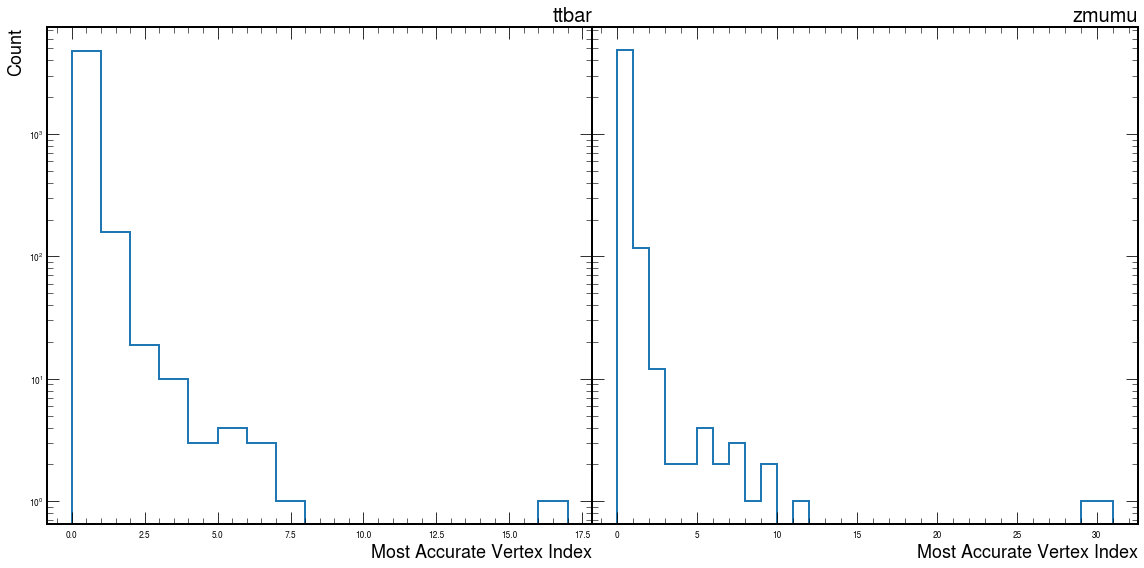

In [38]:
fig, axs = plt.subplots( 1, len(indices), sharex = False, sharey = True, figsize = (16,8) )
axs = axs.flatten()
for i, label in enumerate(labels):
    accurate = sum( np.array( indices[label]["ALL"] ) == 0 )
    second = sum( np.array( indices[label]["ALL"] ) == 1 )
    total = len( indices[label]["ALL"] )
    print( ">> {} Efficiency: {}/{} ({:.2f}%)".format( label, accurate, total, float(accurate/total)*100 ) )
    print( "  - Accurate = 2: {}/{} ({:.2f}%)".format( second, total, float(second/total)*100 ) )
    print( "  - Accurate > 2: {}/{} ({:.2f}%)".format( total - accurate - second, total, float((total-accurate-second)/total)*100 ) )
    this_min = min(indices[label]["ALL"])
    this_max = max(indices[label]["ALL"])
    axs[i].hist(
        indices[label]["ALL"],
        bins = int( this_max - this_min ),
        histtype = "step", linewidth = 2
    )
    axs[i].set_title( label, ha = "right", x = 1.0, fontsize = 20 )
    if i == 0:
        axs[i].set_ylabel( "Count", ha = "right", y = 1.0, fontsize = 18 )
        axs[i].set_yscale( "log" )
    axs[i].set_xlabel( "Most Accurate Vertex Index", ha = "right", x = 1.0, fontsize = 18 )
    
plt.tight_layout()
plt.subplots_adjust( wspace = 0, hspace = 0 )
plt.show()

## Section 2.1: Plot the score distributions for the four categories of vertices
First, plot the total scores

>> ttbar:
  - F+A 8088.605 +/- 11288.789
  - F+NA 3553.378 +/- 6356.453
  - NF+A 1439.373 +/- 3393.804
  - NF+NA 31.065 +/- 229.549
>> zmumu:
  - F+A 2829.099 +/- 4440.426
  - F+NA 2695.758 +/- 5224.577
  - NF+A 1025.646 +/- 797.250
  - NF+NA 23.125 +/- 65.036


/usr/local/bin/start_ipykernel.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


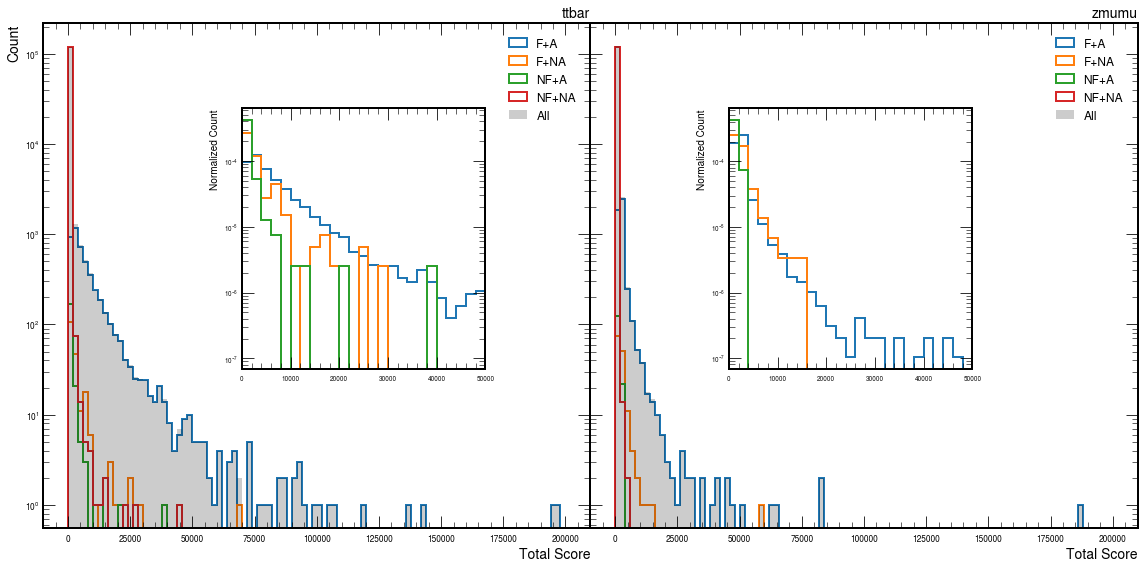

In [11]:
fig, axs = plt.subplots( 1, len(labels), sharex = False, sharey = True, figsize = (8*len(labels),8) )
axs = axs.flatten()
position = [0.25,0.3,0.6,0.6]

for i, label in enumerate( labels ):
    print( ">> {}:".format( label ) )
    subplot = add_subplot( axs[i], position )
    for category in [ "F+A", "F+NA", "NF+A", "NF+NA" ]:
        print( "  - {} {:.3f} +/- {:.3f}".format( 
            category, np.mean(np.array(scores[label]["TOT"][category])), np.std(np.array(scores[label]["TOT"][category])) ) )
        axs[i].hist(
            scores[label]["TOT"][category], bins = np.linspace(0,2e5,101),
            label = category, histtype = "step", linewidth = 2
        )
        if category != "NF+NA":
            subplot.hist(
                scores[label]["TOT"][category], bins = np.linspace(0,2e5,101),
                label = category, histtype = "step", linewidth = 2, density = True
            )
    axs[i].hist(
        scores[label]["TOT"]["ALL"], bins = np.linspace(0,2e5,101),
        label = "All", histtype = "stepfilled", alpha = 0.2, color = "black"
    )
    subplot.set_yscale( "log" )
    subplot.set_ylabel( "Normalized Count", ha = "right", y = 1.0 )
    subplot.set_xlim( 0, 5e4 )
    axs[i].set_title( label, ha = "right", x = 1.0, fontsize = 14 )
    if i == 0: 
        axs[i].set_ylabel( "Count", ha = "right", y = 1.0, fontsize = 14 )
        axs[i].set_yscale( "log" )
    axs[i].set_xlabel( "Total Score", ha = "right", x = 1.0, fontsize = 14 )
    axs[i].legend(loc="best",fontsize=12,borderpad=0.7)
    
plt.tight_layout()
plt.subplots_adjust(wspace=0,hspace=0)
plt.show()

Next, plot the jet contribution

>> ttbar:
  - F+A 6264.955 +/- 9020.324
  - F+NA 2182.807 +/- 3329.580
  - NF+A 1119.668 +/- 2844.653
  - NF+NA 27.821 +/- 135.525
>> zmumu:
  - F+A 2633.340 +/- 3382.882
  - F+NA 1592.743 +/- 2446.349
  - NF+A 793.373 +/- 637.092
  - NF+NA 22.275 +/- 52.362


/usr/local/bin/start_ipykernel.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


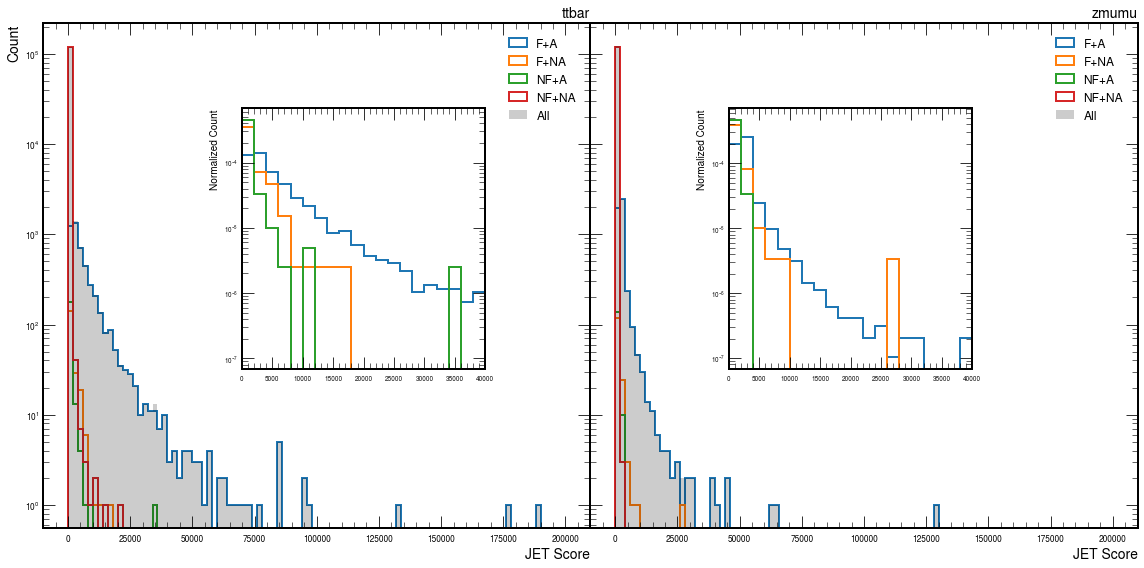

In [12]:
fig, axs = plt.subplots( 1, len(labels), sharex = False, sharey = True, figsize = (8*len(labels),8) )
axs = axs.flatten()
position = [0.25,0.3,0.6,0.6]

for i, label in enumerate( labels ):
    print( ">> {}:".format( label ) )
    subplot = add_subplot( axs[i], position )
    for category in [ "F+A", "F+NA", "NF+A", "NF+NA" ]:
        print( "  - {} {:.3f} +/- {:.3f}".format( 
            category, np.mean(np.array(scores[label]["JET"][category])), np.std(np.array(scores[label]["JET"][category])) ) )
        axs[i].hist(
            scores[label]["JET"][category], bins = np.linspace(0,2e5,101),
            label = category, histtype = "step", linewidth = 2
        )
        if category != "NF+NA":
            subplot.hist(
                scores[label]["JET"][category], bins = np.linspace(0,2e5,101),
                label = category, histtype = "step", linewidth = 2, density = True
            )
    axs[i].hist(
        scores[label]["JET"]["ALL"], bins = np.linspace(0,2e5,101),
        label = "All", histtype = "stepfilled", alpha = 0.2, color = "black"
    )
    subplot.set_yscale( "log" )
    subplot.set_ylabel( "Normalized Count", ha = "right", y = 1.0 )
    subplot.set_xlim( 0, 4e4 )
    axs[i].set_title( label, ha = "right", x = 1.0, fontsize = 14 )
    if i == 0: 
        axs[i].set_ylabel( "Count", ha = "right", y = 1.0, fontsize = 14 )
        axs[i].set_yscale( "log" )
    axs[i].set_xlabel( "JET Score", ha = "right", x = 1.0, fontsize = 14 )
    axs[i].legend(loc="best",fontsize=12,borderpad=0.7)
    
plt.tight_layout()
plt.subplots_adjust(wspace=0,hspace=0)
plt.show()

Finally, plot the MET contribution

>> ttbar:
  - F+A 1823.650 +/- 3863.226
  - F+NA 1370.571 +/- 3238.334
  - NF+A 319.706 +/- 921.215
  - NF+NA 3.244 +/- 103.081
>> zmumu:
  - F+A 195.759 +/- 1448.907
  - F+NA 1103.015 +/- 2831.404
  - NF+A 232.273 +/- 306.559
  - NF+NA 0.849 +/- 19.512


/usr/local/bin/start_ipykernel.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


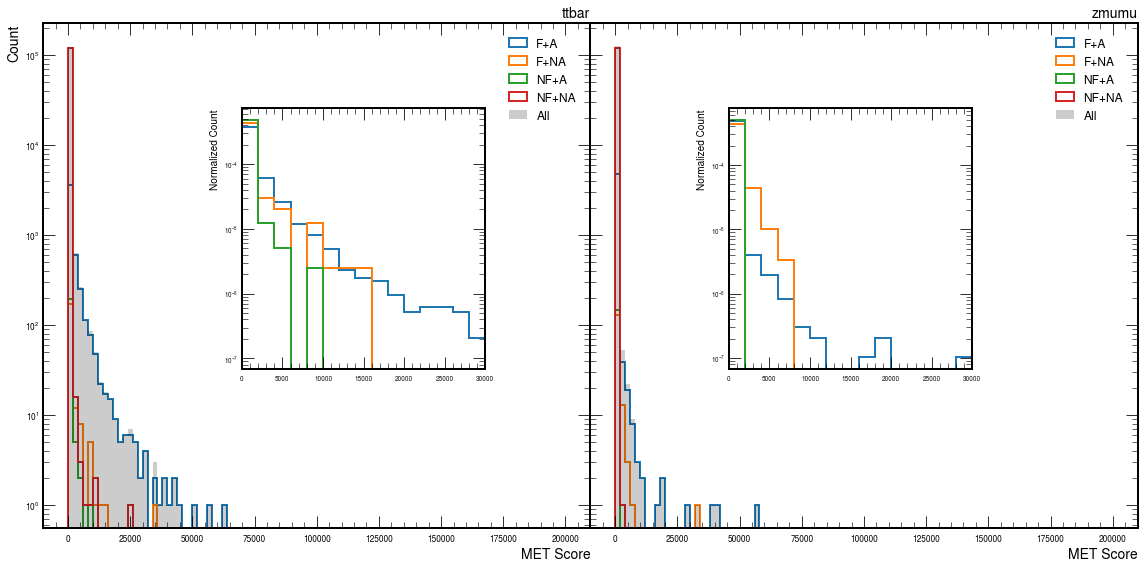

In [13]:
fig, axs = plt.subplots( 1, len(labels), sharex = False, sharey = True, figsize = (8*len(labels),8) )
axs = axs.flatten()
position = [0.25,0.3,0.6,0.6]

for i, label in enumerate( labels ):
    print( ">> {}:".format( label ) )
    subplot = add_subplot( axs[i], position )
    for category in [ "F+A", "F+NA", "NF+A", "NF+NA" ]:
        print( "  - {} {:.3f} +/- {:.3f}".format( 
            category, np.mean(np.array(scores[label]["MET"][category])), np.std(np.array(scores[label]["MET"][category])) ) )
        axs[i].hist(
            scores[label]["MET"][category], bins = np.linspace(0,2e5,101),
            label = category, histtype = "step", linewidth = 2
        )
        if category != "NF+NA":
            subplot.hist(
                scores[label]["MET"][category], bins = np.linspace(0,2e5,101),
                label = category, histtype = "step", linewidth = 2, density = True
            )
    axs[i].hist(
        scores[label]["MET"]["ALL"], bins = np.linspace(0,2e5,101),
        label = "All", histtype = "stepfilled", alpha = 0.2, color = "black"
    )
    subplot.set_yscale( "log" )
    subplot.set_ylabel( "Normalized Count", ha = "right", y = 1.0 )
    subplot.set_xlim( 0, 3e4 )
    axs[i].set_title( label, ha = "right", x = 1.0, fontsize = 14 )
    if i == 0: 
        axs[i].set_ylabel( "Count", ha = "right", y = 1.0, fontsize = 14 )
        axs[i].set_yscale( "log" )
    axs[i].set_xlabel( "MET Score", ha = "right", x = 1.0, fontsize = 14 )
    axs[i].legend(loc="best",fontsize=12,borderpad=0.7)
    
plt.tight_layout()
plt.subplots_adjust(wspace=0,hspace=0)
plt.show()

## Section 2.2: Plot the coordinate distributions of the vertices for the four categories of vertices

>> ttbar:
  - F+A 0.896 +/- 3.651
  - F+NA 1.295 +/- 3.218
  - NF+A 1.348 +/- 3.654
  - NF+NA 0.939 +/- 3.805
>> zmumu:
  - F+A 0.911 +/- 3.669
  - F+NA 1.386 +/- 3.268
  - NF+A 0.978 +/- 3.181
  - NF+NA 0.925 +/- 3.802


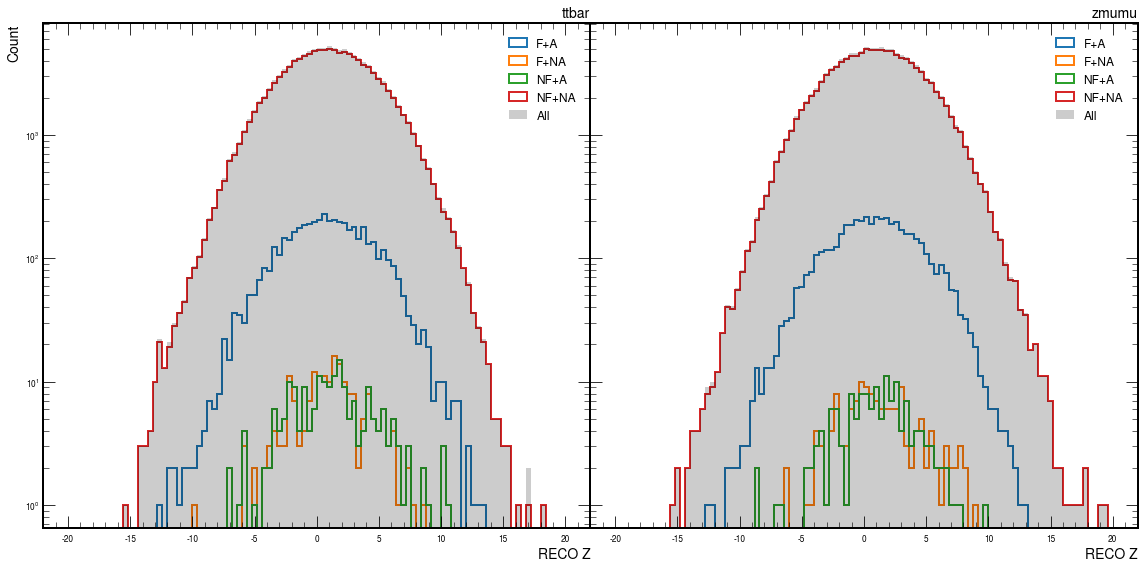

In [14]:
fig, axs = plt.subplots( 1, len(labels), sharex = False, sharey = True, figsize = (8*len(labels),8) )
axs = axs.flatten()

for i, label in enumerate( labels ):
    print( ">> {}:".format( label ) )
    for category in [ "F+A", "F+NA", "NF+A", "NF+NA" ]:
        print( "  - {} {:.3f} +/- {:.3f}".format( 
            category, np.mean(np.array(reco[label]["XYZ"][category])[:,2]), np.std(np.array(reco[label]["XYZ"][category])[:,2]) ) )
        axs[i].hist(
            np.array( reco[label]["XYZ"][category] )[:,2], bins = np.linspace(-20,20,101),
            label = category, histtype = "step", linewidth = 2
        )
    axs[i].hist(
        np.array( reco[label]["XYZ"]["ALL"] )[:,2], bins = np.linspace(-20,20,101),
        label = "All", histtype = "stepfilled", alpha = 0.2, color = "black"
    )
    axs[i].set_title( label, ha = "right", x = 1.0, fontsize = 14 )
    if i == 0: 
        axs[i].set_ylabel( "Count", ha = "right", y = 1.0, fontsize = 14 )
        axs[i].set_yscale( "log" )
    axs[i].set_xlabel( "RECO Z", ha = "right", x = 1.0, fontsize = 14 )
    axs[i].legend(loc="best",fontsize=12,borderpad=0.7)
    
plt.tight_layout()
plt.subplots_adjust(wspace=0,hspace=0)
plt.show()

The distribution of the GEN and RECO distance should reflect the accuracy of the algorithm.  It is expected that the category of a vertex being ranked first and being most accurate has a very narrow distribution, similarly, the category for being most accurate but not ranked first.  

>> ttbar:
  - F+A 0.002 +/- 0.002
  - F+NA 1.043 +/- 2.361
  - NF+A 0.006 +/- 0.005
  - NF+NA 4.181 +/- 3.165
>> zmumu:
  - F+A 0.003 +/- 0.004
  - F+NA 1.592 +/- 2.578
  - NF+A 0.032 +/- 0.231
  - NF+NA 4.227 +/- 3.158


/usr/local/bin/start_ipykernel.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


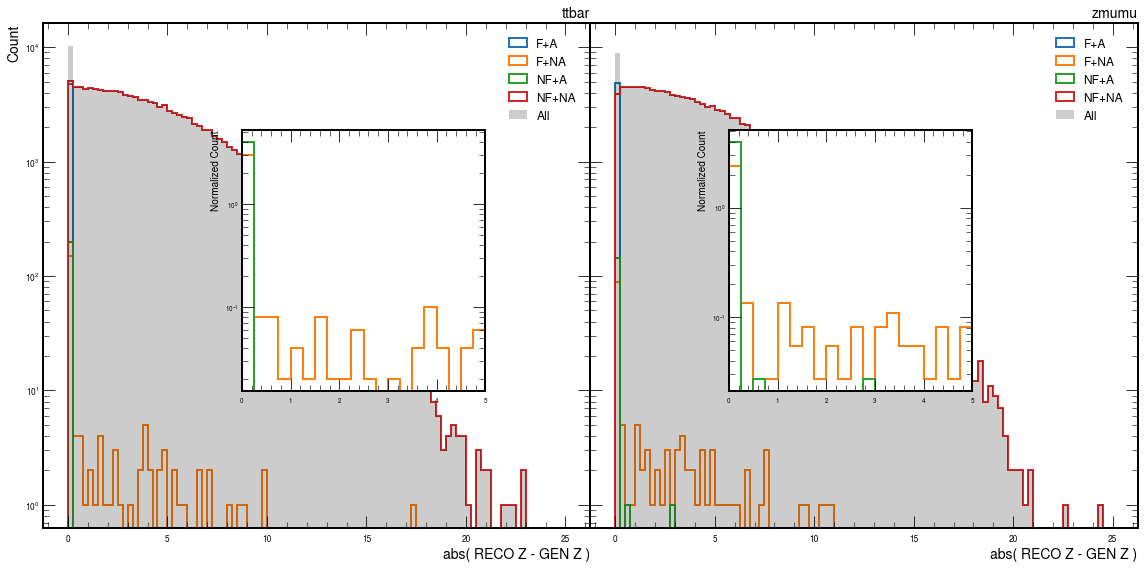

In [15]:
fig, axs = plt.subplots( 1, len(labels), sharex = False, sharey = True, figsize = (8*len(labels),8) )
axs = axs.flatten()
position = [0.25,0.25,0.6,0.6]

for i, label in enumerate( labels ):
    print( ">> {}:".format( label ) )
    subplot = add_subplot( axs[i], position )
    for category in [ "F+A", "F+NA", "NF+A", "NF+NA" ]:
        diff = np.array( reco[label]["XYZ"][category] )[:,2] - np.array( gen[label]["XYZ"][category] )[:,2]
        print( "  - {} {:.3f} +/- {:.3f}".format( 
            category, np.mean(abs(diff)), np.std(abs(diff)) ) )
        axs[i].hist(
            abs(diff), bins = np.linspace(0,25,101),
            label = category, histtype = "step", linewidth = 2
        )
        if category != "NF+NA":
            subplot.hist(
                abs(diff), bins = np.linspace(0,25,101),
                label = category, histtype = "step", linewidth = 2, density = True
            )
    axs[i].hist(
        abs( np.array( reco[label]["XYZ"]["ALL"] )[:,2] - np.array( gen[label]["XYZ"]["ALL"] )[:,2] ),
        bins = np.linspace(0,25,101),
        label = "All", histtype = "stepfilled", alpha = 0.2, color = "black"
    )
    subplot.set_yscale( "log" )
    subplot.set_ylabel( "Normalized Count", ha = "right", y = 1.0 )
    subplot.set_xlim( 0, 5 )
    axs[i].set_title( label, ha = "right", x = 1.0, fontsize = 14 )
    if i == 0: 
        axs[i].set_ylabel( "Count", ha = "right", y = 1.0, fontsize = 14 )
        axs[i].set_yscale( "log" )
    axs[i].set_xlabel( "abs( RECO Z - GEN Z )", ha = "right", x = 1.0, fontsize = 14 )
    axs[i].legend(loc="best",fontsize=12,borderpad=0.7)
    
plt.tight_layout()
plt.subplots_adjust(wspace=0,hspace=0)
plt.show()

Plot the distribution of the RECO distance between the most accurate vertex and the top ranked vertex when the indices are not the same. This plot does not have too much meaning on its own, perhaps except to provide an idea of how much of a discrepancy there is in the top ranked versus most accurate coordinates. This type of relative distance may provide a useful discriminator when re-considering the sorting, however.

>> ttbar:
  - 0.053 +/- 2.581
>> zmumu:
  - -0.408 +/- 2.983


/usr/local/bin/start_ipykernel.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


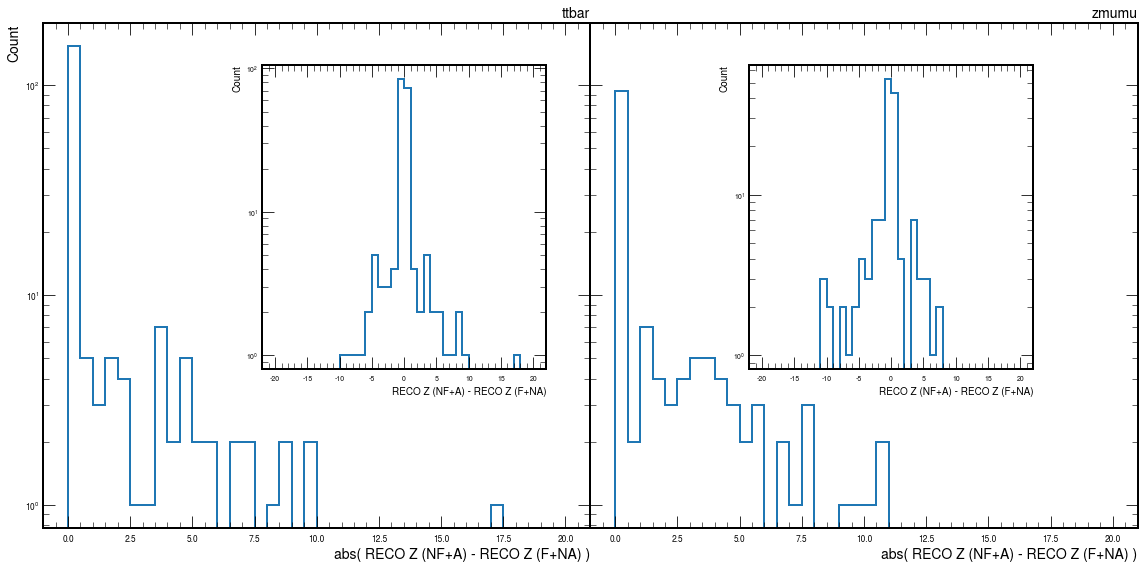

In [37]:
fig, axs = plt.subplots( 1, len(labels), sharex = False, sharey = True, figsize = (8*len(labels),8) )
axs = axs.flatten()
position = [0.3,0.3,0.7,0.7]

for i, label in enumerate( labels ):
    subplot = add_subplot( axs[i], position )
    print( ">> {}:".format( label ) )
    diff = np.array( reco[label]["XYZ"]["NF+A"] )[:,2] - np.array( reco[label]["XYZ"]["F+NA"] )[:,2]
    print( "  - {:.3f} +/- {:.3f}".format( 
        np.mean(diff), np.std(diff) ) )
    axs[i].hist(
        abs(diff), bins = np.linspace(0,20,41),
        histtype = "step", linewidth = 2
    )
    subplot.hist(
        diff, bins = np.linspace(-20,20,41),
        histtype = "step", linewidth = 2
    )
    subplot.set_ylabel( "Count", ha = "right", y = 1.0 )
    subplot.set_yscale( "log" )
    subplot.set_xlabel( "RECO Z (NF+A) - RECO Z (F+NA)", ha = "right", x = 1.0 )
    axs[i].set_title( label, ha = "right", x = 1.0, fontsize = 14 )
    if i == 0: 
        axs[i].set_ylabel( "Count", ha = "right", y = 1.0, fontsize = 14 )
        axs[i].set_yscale( "log" )
    axs[i].set_xlabel( "abs( RECO Z (NF+A) - RECO Z (F+NA) )", ha = "right", x = 1.0, fontsize = 14 )
    
plt.tight_layout()
plt.subplots_adjust(wspace=0,hspace=0)
plt.show()

### Section 2.3: Plot the timing information for the four different vertexing categories

>> ttbar:
  - F+A 255.481 +/- 159.756
  - F+NA 128.826 +/- 124.848
  - NF+A 121.198 +/- 84.064
  - NF+NA 28.843 +/- 29.376
>> zmumu:
  - F+A 216.735 +/- 108.950
  - F+NA 150.348 +/- 103.284
  - NF+A 124.897 +/- 75.805
  - NF+NA 28.842 +/- 29.512


/usr/local/bin/start_ipykernel.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


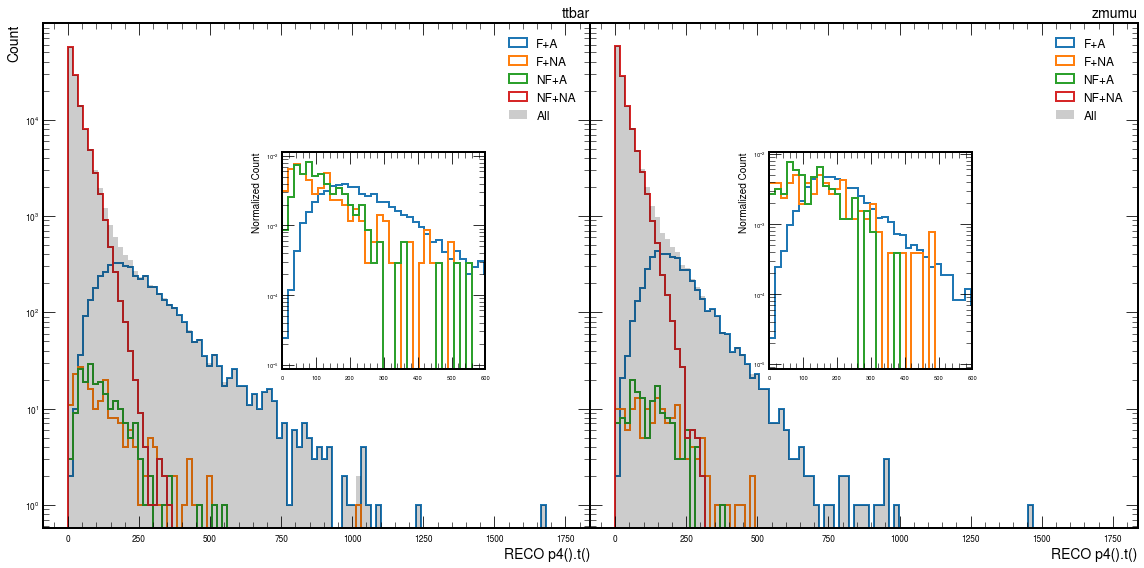

In [17]:
fig, axs = plt.subplots( 1, len(labels), sharex = False, sharey = True, figsize = (8*len(labels),8) )
axs = axs.flatten()
position = [0.35,0.3,0.5,0.5]

for i, label in enumerate( labels ):
    print( ">> {}:".format( label ) )
    subplot = add_subplot( axs[i], position )
    for category in [ "F+A", "F+NA", "NF+A", "NF+NA" ]:
        print( "  - {} {:.3f} +/- {:.3f}".format( 
            category, np.mean( reco[label]["T"][category] ), np.std( reco[label]["T"][category]) ) )
        axs[i].hist(
            reco[label]["T"][category], bins = np.linspace(0,1750,101),
            label = category, histtype = "step", linewidth = 2
        )
        if category != "NF+NA":
            subplot.hist(
                reco[label]["T"][category], bins = np.linspace(0,1750,101),
                label = category, histtype = "step", linewidth = 2, density = True
            )
    axs[i].hist(
        reco[label]["T"]["ALL"], bins = np.linspace(0,1750,101),
        label = "All", histtype = "stepfilled", alpha = 0.2, color = "black"
    )
    subplot.set_ylabel( "Normalized Count", ha = "right", y = 1.0 )
    subplot.set_yscale( "log" )
    subplot.set_xlim( 0, 600 )
    axs[i].set_title( label, ha = "right", x = 1.0, fontsize = 14 )
    if i == 0: 
        axs[i].set_ylabel( "Count", ha = "right", y = 1.0, fontsize = 14 )
        axs[i].set_yscale( "log" )
    axs[i].set_xlabel( "RECO p4().t()", ha = "right", x = 1.0, fontsize = 14 )
    axs[i].legend(loc="best",fontsize=12,borderpad=0.7)
    
plt.tight_layout()
plt.subplots_adjust(wspace=0,hspace=0)
plt.show()

Plot the distribution of the difference in timing between the most accurate vertex and first ranked vertex when the indices are not the same.

>> ttbar:
  - 88.566 +/- 87.901
>> zmumu:
  - 100.247 +/- 83.991


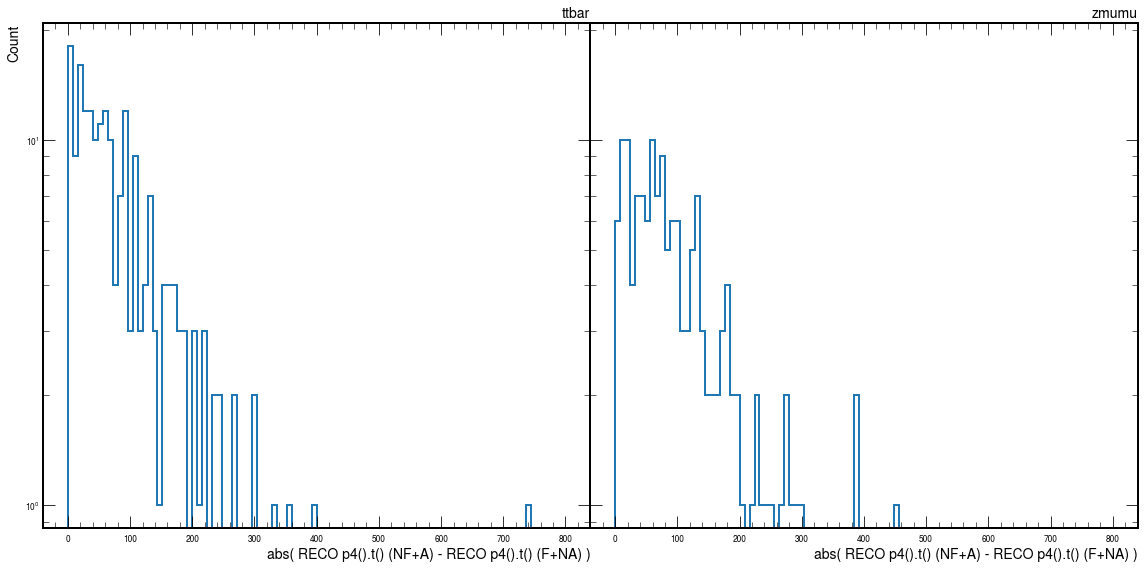

In [23]:
fig, axs = plt.subplots( 1, len(labels), sharex = False, sharey = True, figsize = (8*len(labels),8) )
axs = axs.flatten()

for i, label in enumerate( labels ):
    print( ">> {}:".format( label ) )
    diff = np.array( reco[label]["T"]["NF+A"] ) - np.array( reco[label]["T"]["F+NA"] )
    print( "  - {:.3f} +/- {:.3f}".format( 
        np.mean(abs(diff)), np.std(abs(diff)) ) )
    axs[i].hist(
        abs(diff), bins = np.linspace(0,800,101),
        label = category, histtype = "step", linewidth = 2
    )
    axs[i].set_title( label, ha = "right", x = 1.0, fontsize = 14 )
    if i == 0: 
        axs[i].set_ylabel( "Count", ha = "right", y = 1.0, fontsize = 14 )
        axs[i].set_yscale( "log" )
    axs[i].set_xlabel( "abs( RECO p4().t() (NF+A) - RECO p4().t() (F+NA) )", ha = "right", x = 1.0, fontsize = 14 )
    
plt.tight_layout()
plt.subplots_adjust(wspace=0,hspace=0)
plt.show()

# Section 3: Scatter Plots

### Section 3.1: Plotting Distributions for the Accurate Vertices Against their Index

Compare the various score contributions against the accurate index for events where the first ranked is not the most accurate

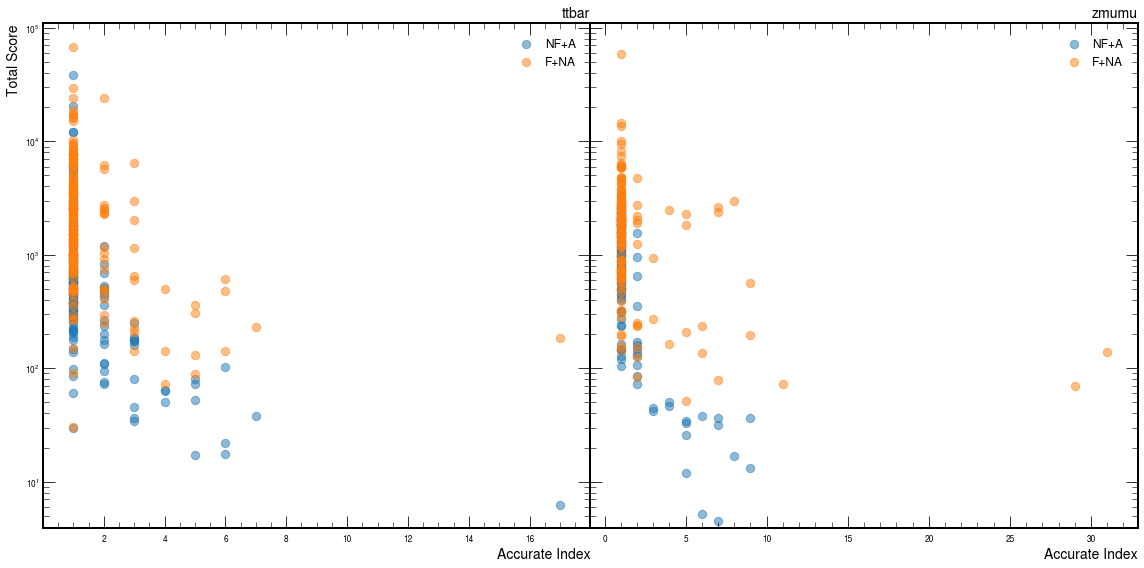

In [28]:
fig, axs = plt.subplots( 1, len(labels), sharex = False, sharey = True, figsize = (8*len(labels),8) )
axs = axs.flatten()
position = [0.3,0.3,0.5,0.5]

for i, label in enumerate( labels ):
    axs[i].scatter(
        indices[label]["NF+A"], scores[label]["TOT"]["NF+A"],
        label = "NF+A", s = 70, alpha = 0.5
    )
    axs[i].scatter(
        indices[label]["NF+A"], scores[label]["TOT"]["F+NA"],
        label = "F+NA", s = 70, alpha = 0.5
    )
    axs[i].set_title( label, ha = "right", x = 1.0, fontsize = 14 )
    if i == 0: 
        axs[i].set_ylabel( "Total Score", ha = "right", y = 1.0, fontsize = 14 )
        axs[i].set_yscale( "log" )
    axs[i].set_xlabel( "Accurate Index", ha = "right", x = 1.0, fontsize = 14 )
    axs[i].legend(loc="best",fontsize=12,borderpad=0.7)
    
plt.tight_layout()
plt.subplots_adjust(wspace=0,hspace=0)
plt.show()

#

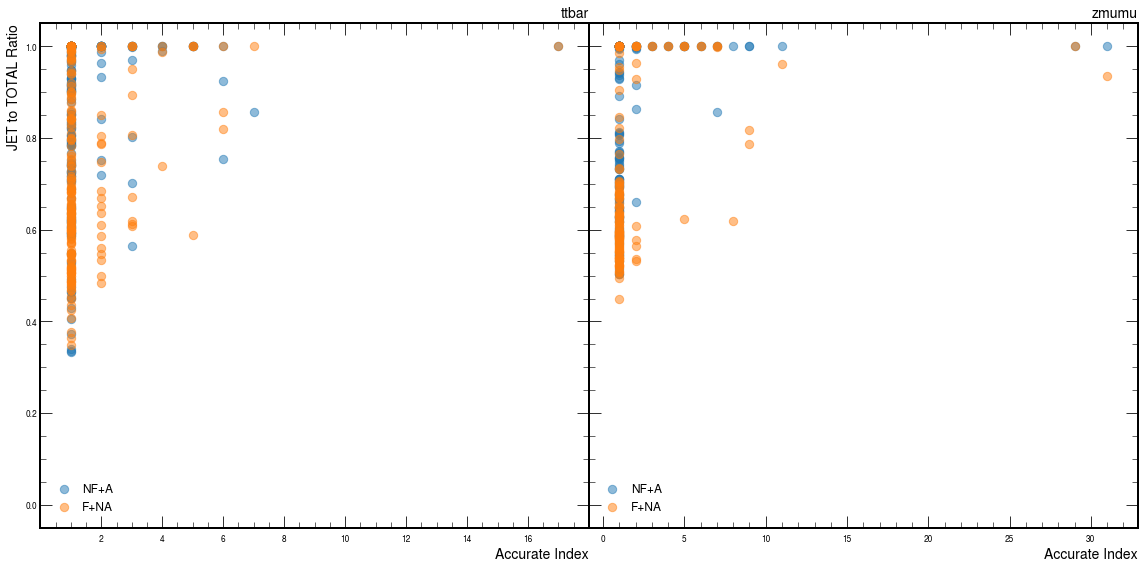

In [35]:
fig, axs = plt.subplots( 1, len(labels), sharex = False, sharey = True, figsize = (8*len(labels),8) )
axs = axs.flatten()
position = [0.3,0.3,0.5,0.5]

for i, label in enumerate( labels ):
    axs[i].scatter(
        indices[label]["NF+A"], np.array( scores[label]["JET"]["NF+A"] ) / np.array( scores[label]["TOT"]["NF+A"] ),
        label = "NF+A", s = 70, alpha = 0.5
    )
    axs[i].scatter(
        indices[label]["NF+A"], np.array( scores[label]["JET"]["F+NA"] ) / np.array( scores[label]["TOT"]["F+NA"] ),
        label = "F+NA", s = 70, alpha = 0.5
    )
    axs[i].set_title( label, ha = "right", x = 1.0, fontsize = 14 )
    if i == 0: 
        axs[i].set_ylabel( "JET to TOTAL Ratio", ha = "right", y = 1.0, fontsize = 14 )
        axs[i].set_ylim(-0.05,1.05)
    axs[i].set_xlabel( "Accurate Index", ha = "right", x = 1.0, fontsize = 14 )
    axs[i].legend(loc="best",fontsize=12,borderpad=0.7)
    
plt.tight_layout()
plt.subplots_adjust(wspace=0,hspace=0)
plt.show()

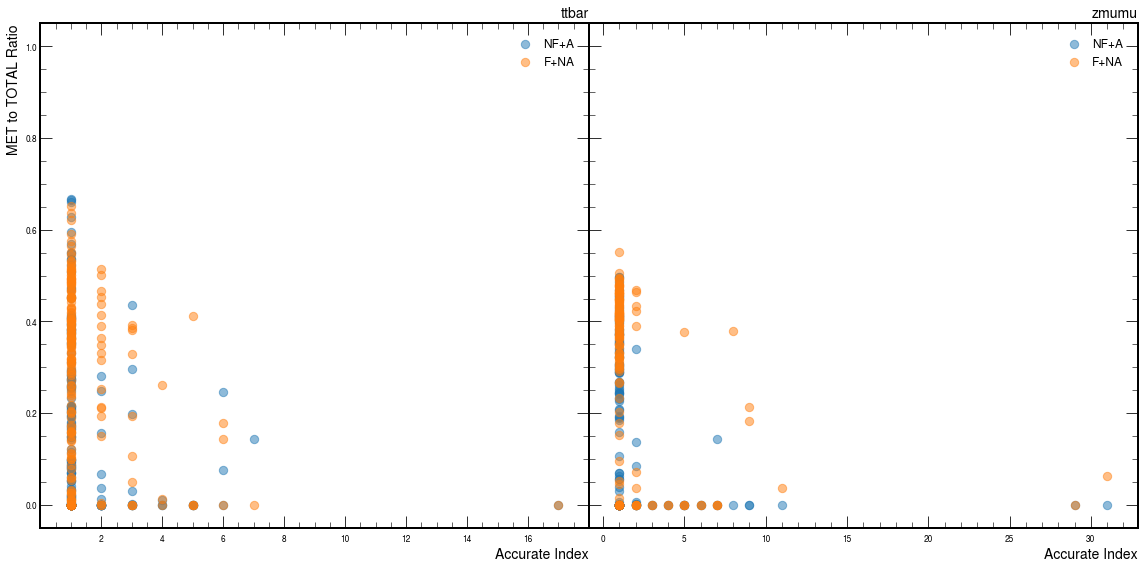

In [36]:
fig, axs = plt.subplots( 1, len(labels), sharex = False, sharey = True, figsize = (8*len(labels),8) )
axs = axs.flatten()
position = [0.3,0.3,0.5,0.5]

for i, label in enumerate( labels ):
    axs[i].scatter(
        indices[label]["NF+A"], np.array( scores[label]["MET"]["NF+A"] ) / np.array( scores[label]["TOT"]["NF+A"] ),
        label = "NF+A", s = 70, alpha = 0.5
    )
    axs[i].scatter(
        indices[label]["NF+A"], np.array( scores[label]["MET"]["F+NA"] ) / np.array( scores[label]["TOT"]["F+NA"] ),
        label = "F+NA", s = 70, alpha = 0.5
    )
    axs[i].set_title( label, ha = "right", x = 1.0, fontsize = 14 )
    if i == 0: 
        axs[i].set_ylabel( "MET to TOTAL Ratio", ha = "right", y = 1.0, fontsize = 14 )
        axs[i].set_ylim(-0.05,1.05)
    axs[i].set_xlabel( "Accurate Index", ha = "right", x = 1.0, fontsize = 14 )
    axs[i].legend(loc="best",fontsize=12,borderpad=0.7)
    
plt.tight_layout()
plt.subplots_adjust(wspace=0,hspace=0)
plt.show()

Compare the RECO z-distance difference between the top ranked vertex, when it is not the most accurate, and the subsequently ranked vertices. Compare these distributions separately for when the subsequent vertices are either the most accurate or not the most accurate.

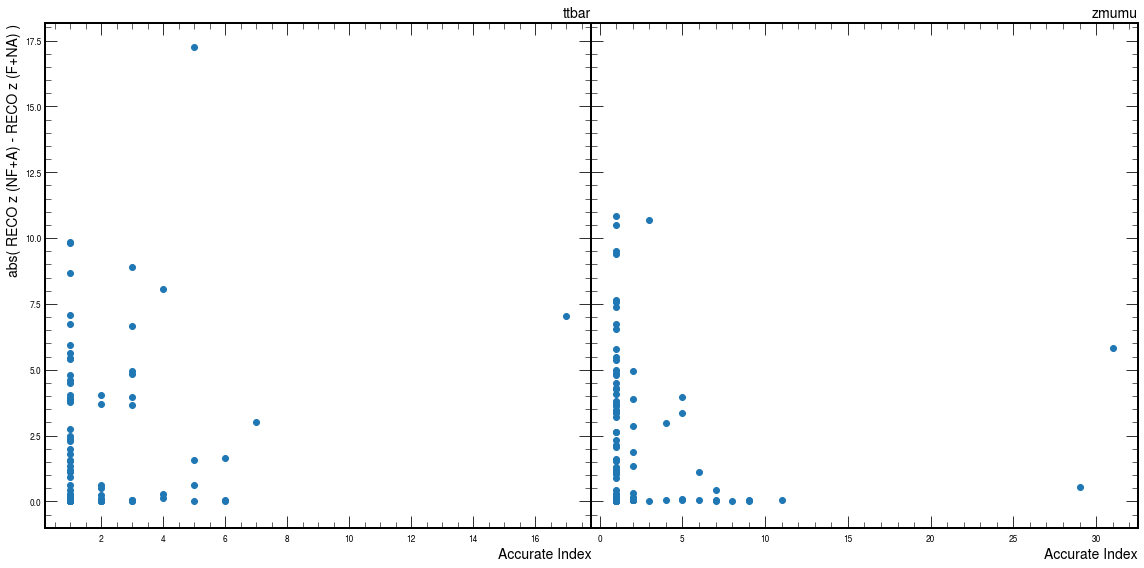

In [19]:
fig, axs = plt.subplots( 1, len(labels), sharex = False, sharey = True, figsize = (8*len(labels),8) )
axs = axs.flatten()
position = [0.3,0.3,0.5,0.5]

for i, label in enumerate( labels ):
    diff = np.array( reco[label]["XYZ"]["NF+A"] )[:,2] - np.array( reco[label]["XYZ"]["F+NA"] )[:,2]
    axs[i].scatter(
        indices[label]["NF+A"], abs(diff)
    )
    axs[i].set_title( label, ha = "right", x = 1.0, fontsize = 14 )
    if i == 0: 
        axs[i].set_ylabel( "abs( RECO z (NF+A) - RECO z (F+NA) )", ha = "right", y = 1.0, fontsize = 14 )
    axs[i].set_xlabel( "Accurate Index", ha = "right", x = 1.0, fontsize = 14 )
    
plt.tight_layout()
plt.subplots_adjust(wspace=0,hspace=0)
plt.show()

Compare the RECO p4().t() difference between the top ranked vertex, when it is not the most accurate, and the subsequently ranked vertices. Compare these distributions separately for when the subsequent vertices are either the most accurate or not the most accurate.

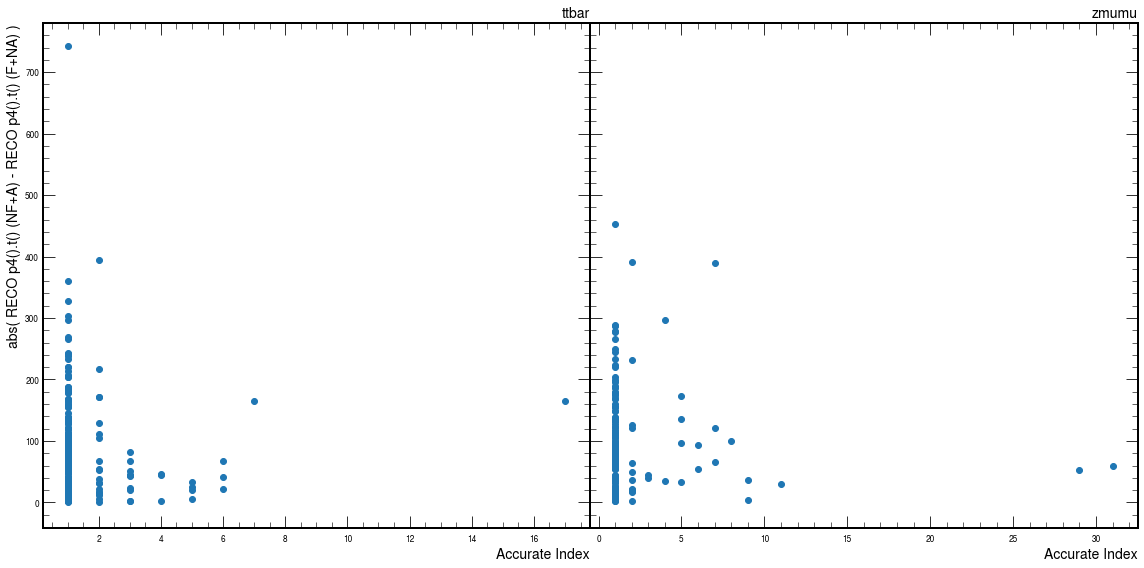

In [20]:
fig, axs = plt.subplots( 1, len(labels), sharex = False, sharey = True, figsize = (8*len(labels),8) )
axs = axs.flatten()
position = [0.3,0.3,0.5,0.5]

for i, label in enumerate( labels ):
    diff = np.array( reco[label]["T"]["NF+A"] ) - np.array( reco[label]["T"]["F+NA"] )
    axs[i].scatter(
        indices[label]["NF+A"], abs(diff)
    )
    axs[i].set_title( label, ha = "right", x = 1.0, fontsize = 14 )
    if i == 0: 
        axs[i].set_ylabel( "abs( RECO p4().t() (NF+A) - RECO p4().t() (F+NA) )", ha = "right", y = 1.0, fontsize = 14 )
    axs[i].set_xlabel( "Accurate Index", ha = "right", x = 1.0, fontsize = 14 )
    
plt.tight_layout()
plt.subplots_adjust(wspace=0,hspace=0)
plt.show()

### Section 3.2: Plotting Distributions Comparing the First Ranked and Most Accurate Vertices

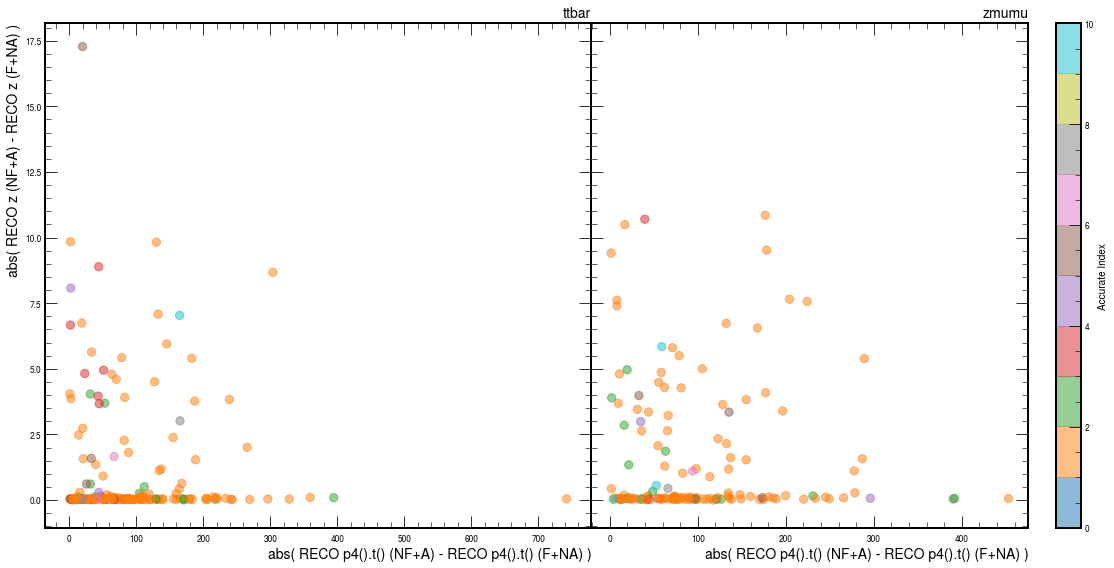

In [21]:
fig, axs = plt.subplots( 1, len(labels), sharex = False, sharey = True, figsize = (8*len(labels),8) )
axs = axs.flatten()
position = [0.3,0.3,0.5,0.5]

for i, label in enumerate( labels ):
    diff_t = np.array( reco[label]["T"]["NF+A"] ) - np.array( reco[label]["T"]["F+NA"] )
    diff_z = np.array( reco[label]["XYZ"]["NF+A"] )[:,2] - np.array( reco[label]["XYZ"]["F+NA"] )[:,2] 
    scatter = axs[i].scatter(
        abs(diff_t), abs(diff_z), c = indices[label]["NF+A"], cmap = plt.cm.get_cmap( "tab10" ),
        vmin = 0, vmax = 10,
        s = 70, alpha = 0.5
    )
    axs[i].set_title( label, ha = "right", x = 1.0, fontsize = 14 )
    if i == 0: 
        axs[i].set_ylabel( "abs( RECO z (NF+A) - RECO z (F+NA) )", ha = "right", y = 1.0, fontsize = 14 )
    axs[i].set_xlabel( "abs( RECO p4().t() (NF+A) - RECO p4().t() (F+NA) )", ha = "right", x = 1.0, fontsize = 14 )
    
fig.colorbar( scatter, ax = axs[-1], label = "Accurate Index" )
plt.tight_layout()
plt.subplots_adjust(wspace=0,hspace=0)
plt.show()

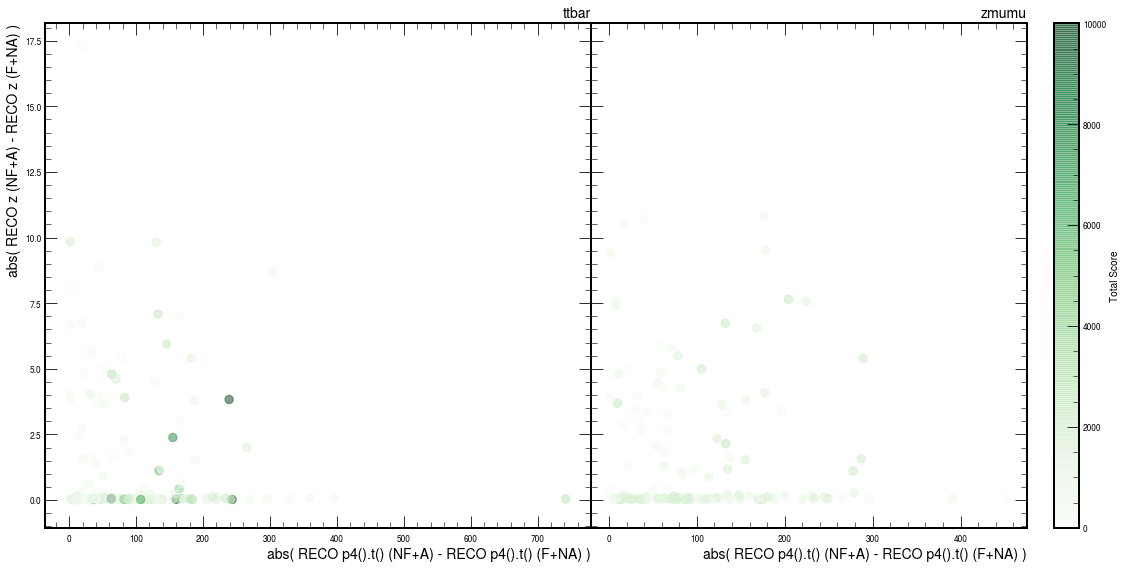

In [22]:
fig, axs = plt.subplots( 1, len(labels), sharex = False, sharey = True, figsize = (8*len(labels),8) )
axs = axs.flatten()
position = [0.3,0.3,0.5,0.5]

for i, label in enumerate( labels ):
    diff_t = np.array( reco[label]["T"]["NF+A"] ) - np.array( reco[label]["T"]["F+NA"] )
    diff_z = np.array( reco[label]["XYZ"]["NF+A"] )[:,2] - np.array( reco[label]["XYZ"]["F+NA"] )[:,2] 
    scatter = axs[i].scatter(
        abs(diff_t), abs(diff_z), c = scores[label]["TOT"]["NF+A"], cmap = plt.cm.get_cmap( "Greens" ),
        vmin = 0, vmax = 1e4,
        s = 70, alpha = 0.5
    )
    axs[i].set_title( label, ha = "right", x = 1.0, fontsize = 14 )
    if i == 0: 
        axs[i].set_ylabel( "abs( RECO z (NF+A) - RECO z (F+NA) )", ha = "right", y = 1.0, fontsize = 14 )
    axs[i].set_xlabel( "abs( RECO p4().t() (NF+A) - RECO p4().t() (F+NA) )", ha = "right", x = 1.0, fontsize = 14 )
    
fig.colorbar( scatter, ax = axs[-1], label = "Total Score" )
plt.tight_layout()
plt.subplots_adjust(wspace=0,hspace=0)
plt.show()

## Section 4: Applying timing information for re-ranking

One idea is that we can treat the difference between the z-coordinate and time between the top ranked vertex and second ranked as a discriminator to decide if we want to re-evaluate the ranking of those two vertices.

We want to find a way to increase the efficiency by upgrading events that have the most accurate vertex ranked second.  First, we need some type of discriminator that indicates that we should re-consider an event, and this should be derived from the existing information, preferrably between the characteristics of the first and second ranked vertices. Then, we need a second discriminator to determine if we actually upgrade that second ranked vertex.  Finally, compare the efficiency after implementing the secondary discriminator: How many vertices were flipped correctly/incorrectly? Did this improve the efficiency?  
* If a set of discriminators can be found to achieve the above, then we can consider how this information can be naturally incorporated into the algorithm.